# pyTigerGraph

This notebook will walk you through all of the features that pyTigerGraph offers.
Before we get started you will need a TigerGraph instance of your own. You can [spin one up yourself](https://info.tigergraph.com/enterprise-free) or use [one of our free cloud instances](https://tgcloud.io/).

We'll be using the **Recommendation Engine (Movie Recommendation)** example. If you're using TigerGraph Cloud, you can select this sample when creating your cloud solution. Otherwise, you can download the sameple [here](https://www.tigergraph.com/starterkits/) for your installed version of TigerGraph.

I'll be using a TG Cloud instance for this example, but the only differences should come down to your connection url.


## Getting a Secret

Before we can start making requests to our graph, we need to procure a secret. This can be done via either GSQL or the GraphStudio web interface. I'll outline both processes here, you only need to run one of these examples.

### A la GSQL
You can run these GSQL commands in GSQL mode while in a shell on the machine running TigerGraph.
The full list of secret managment commands is available [here](https://docs.tigergraph.com/admin/admin-guide/user-access/user-privileges-and-authentication#secrets) but for the purpose of this example we'll only be using


```
CREATE SECRET [alias]
```

#### From Shell
First open a GSQL session with the user and graph that you will be creating the secret for. 


```
$ gsql -u [username] -g [graph_name]
```
You will be prompted for your password, then the GSQL Shell will open.
Run the GSQL command 
```
CREATE SECRET [alias]
```
with 'alias' being the name your want to give the secret.
You can always view your secret later with
```
SHOW SECRET
```
but you'll need that secret for the next steps so it's best to copy it to the clipboard for now.



### From GraphStudio
If you don't have access to a shell running on the TigerGraph machine, you can also create a secret via the admin portal in GraphStudio.

To do this, click the 'Admin' button in the top right corner of the GraphStudio web interface to be brough to the Admin Portal.

Click 'Users' under 'Management' in the navigation bar.
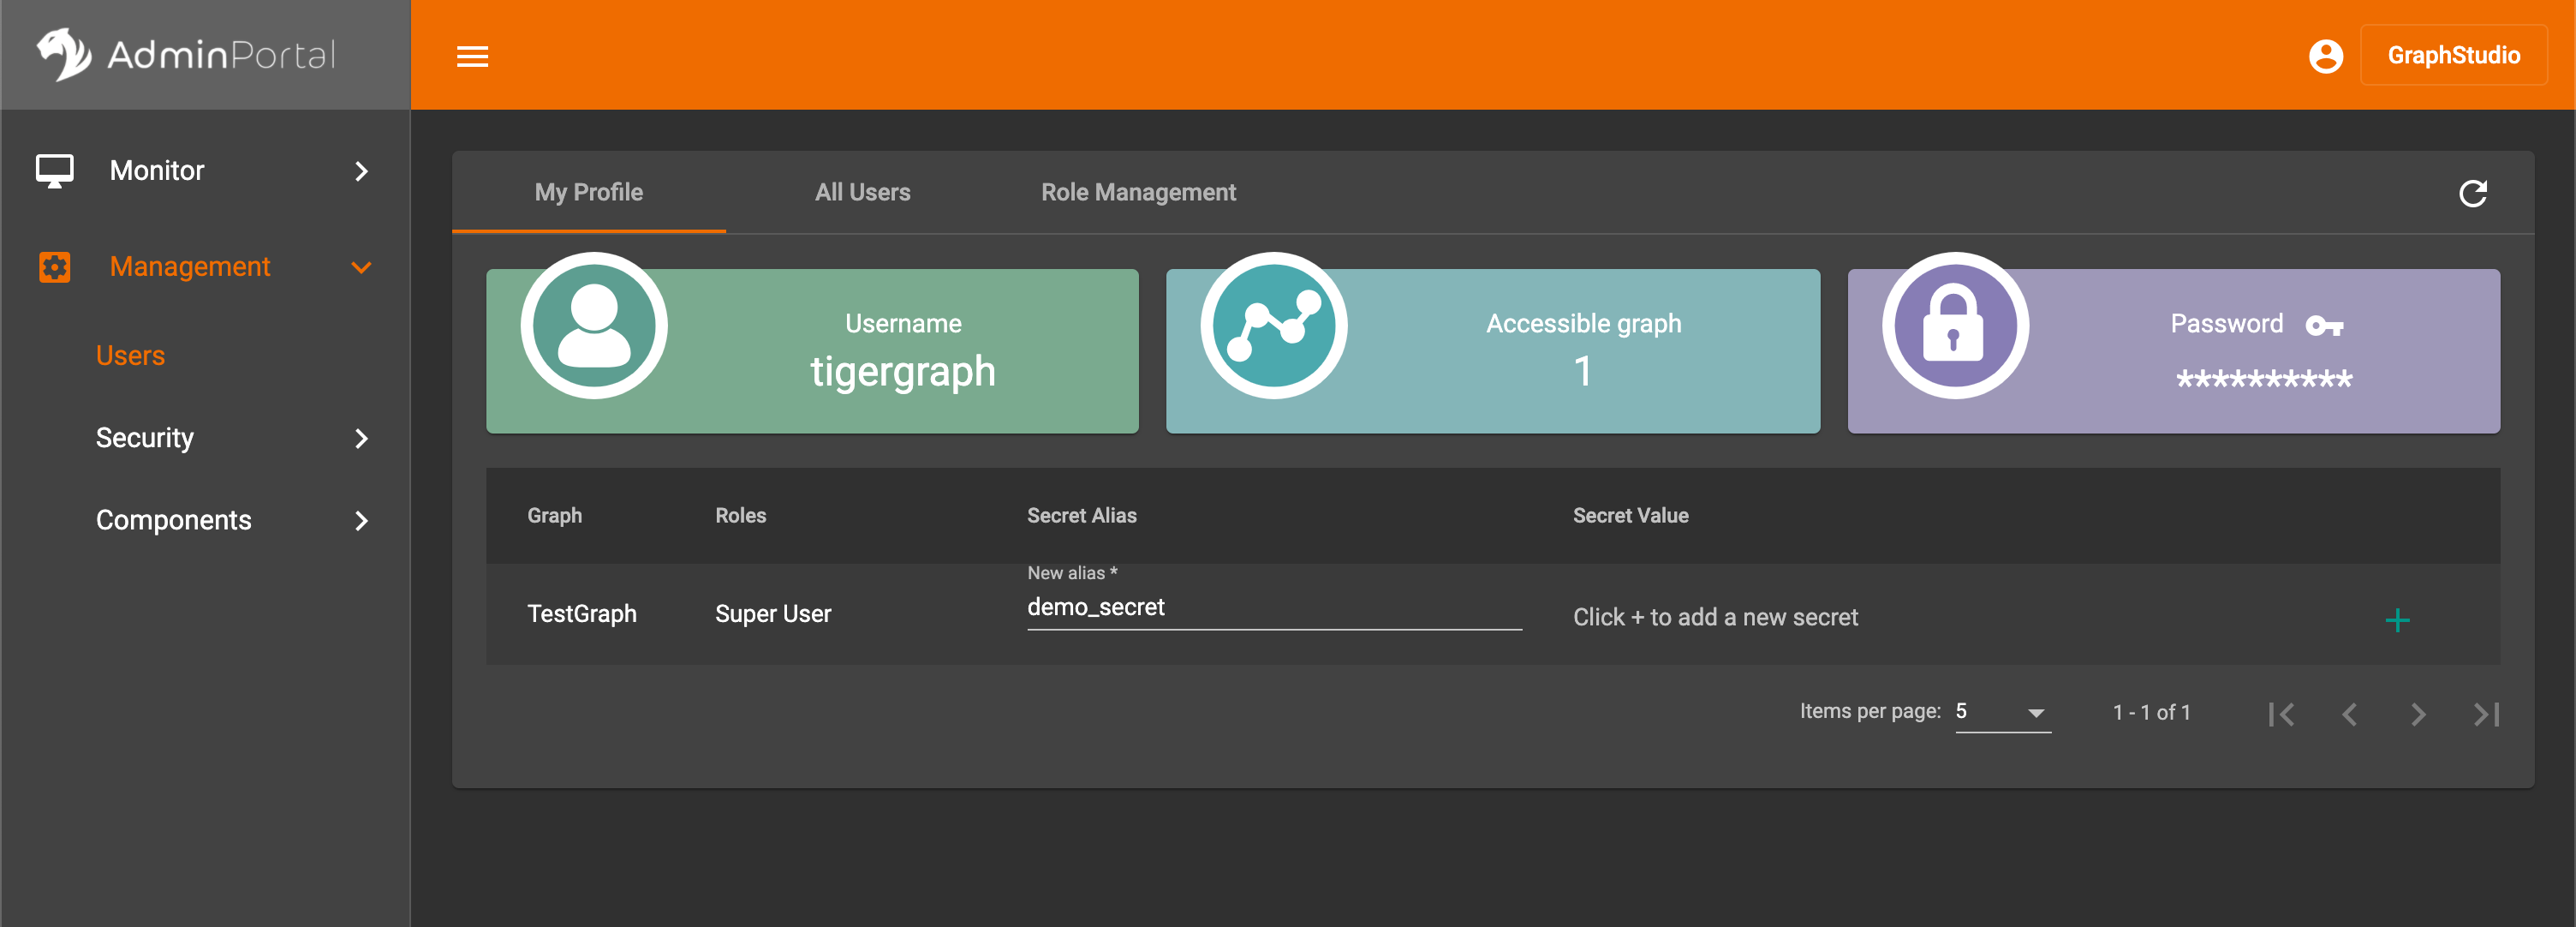
Type in an alias and click the plus icon on the right side of the screen to create your secret.

## Connecting Through PyTigerGraph
Now that we have a secret, we have everything we need to start our pyTigerGraph connection.

First we need to install and import our pyTigerGraph package

In [ ]:
!pip install pyTigerGraph

In [ ]:
import pyTigerGraph as tg

Some additional imports to help the demo run smoothly

In [ ]:
import json
import pandas as pd

## Grab a New Token

TigerGraph has numerous [built-in REST endpoints](https://docs.tigergraph.com/dev/restpp-api/built-in-endpoints) including the abilty to create TOKENS. For a complete list with the details or each of those endpoints I would suggest checking out the documentaion at [docs.tigergraph.com](https://docs.tigergraph.com/dev/restpp-api/built-in-endpoints)

We'll need a few bits of information to get our token so that we can connect to our TG instance.
- IP Address: Your DNS without port `"https://pytigerdocs.i.tgcloud.io"`
- Graphname: Your graph name `"MyGraph"`
- Secret: Your secret from the previous step `"jnvki520kpcqg4db4kikadc18fk65l43"`
- Username: The username of the TigerGraph user that will be accessing the graph (what you use the log into GraphStudio)(default is 'tigergraph') `"tigergraph"`
- Password: The password for the above user `"tigergraph"`

In [ ]:
hostName = "https://energy-weather-1.i.tgcloud.io"
graphName = "MyGraph"
secret = "phd37nvkrlh6t5t3btrnf6md4rgm80iq"
userName = "tigergraph"
password = "tigergraph"

In [ ]:
conn = tg.TigerGraphConnection(host=hostName, username=userName, password=password)

In [ ]:
conn.gsql('''DROP VERTEX person FROM MyGraph''')

Connection Failed check your Username/Password [Errno 110] Connection timed out
Couldn't Initialize the client see Above Error


NameError: ignored

In [ ]:
graph = tg.TigerGraphConnection(host=hostName, graphname=graphName)

authToken = graph.getToken(secret)
authToken = authToken[0]
print(f"SHHHH.... Keep this a secret. Here's your token:\n {authToken}")

SHHHH.... Keep this a secret. Here's your token:
 s966iqc1639et8k714sh7gl4gu9traqq


And there it is. With that token you're now able to authenticate the full functionality of pyTigerGraph.

Next up we'll go through every feature of pyTigerGraph so you can start maximizing your python TigerGraph projects.

# The Basics
We have to start somewhere, so might as well make it the simple stuff. I'm going to assume that you're starting with the Movie Recommendation solution at this point, it may be helpful to make sure you're using that solution, or get it set up.

This first set of commands will help us get familiar with the schema of our graph and explore what we're working with.

## Establish Connection
The line below establishes the connection that future pyTigerGraph commands will use. **If you're coming back to this notebook, run this line to establish your connection otherwise your pyTigerGraph commands won't work.**

In [ ]:
conn = tg.TigerGraphConnection(host=hostName, graphname=graphName, username=userName, password=password, apiToken=authToken)
print(conn)

## Getting the Schema
Now let's take a peek at our schema to see what our graph looks like.

In [ ]:
results = conn.getSchema()
print(json.dumps(results, indent=2))

### Reading the Output
Woah, that's a lot of text! Let's break it down and see what we're really looking at. 
```
"GraphName": "MyGraph",
```
That one is easy, that's our graph name.

#### Verticies
```
"VertexTypes": [
    {
      "Config": {
        "TAGGABLE": false,
        "STATS": "OUTDEGREE_BY_EDGETYPE",
        "PRIMARY_ID_AS_ATTRIBUTE": false
      },
      "Attributes": [],
      "PrimaryId": {
        "AttributeType": {
          "Name": "STRING"
        },
        "IsPartOfCompositeKey": false,
        "PrimaryIdAsAttribute": false,
        "AttributeName": "id",
        "HasIndex": false,
        "internalAttribute": false,
        "IsPrimaryKey": false
      },
      "Name": "person"
    },
```
This is our first vertex type. We can see via the **Name** property at the bottom that this is our **person** vertex.
Digging in a bit more, we can see that our **person** vertex **does not** have any attributes. 

In this case, the **PrimaryId** is the only part of this vertex that contains info. It is important to note that while **PrimaryId** is not an attribute, it can still be referenced like one during querying. We can see our **PrimaryId** has an **AttributeName** referred to as **id** and whose **AttributeType** is **STRING**.

Using this, can you figure out what our other vertex is and what its attributes are?


#### Edges
Next are our edge types
```
"EdgeTypes": [
    {
      "IsDirected": true,
      "ToVertexTypeName": "movie",
      "Config": {
        "REVERSE_EDGE": "reverse_rate"
      },
      "Attributes": [
        {
          "AttributeType": {
            "Name": "DOUBLE"
          },
          "IsPartOfCompositeKey": false,
          "PrimaryIdAsAttribute": false,
          "AttributeName": "rating",
          "HasIndex": false,
          "internalAttribute": false,
          "IsPrimaryKey": false
        },
        {
          "AttributeType": {
            "Name": "DATETIME"
          },
          "IsPartOfCompositeKey": false,
          "PrimaryIdAsAttribute": false,
          "AttributeName": "rated_at",
          "HasIndex": false,
          "internalAttribute": false,
          "IsPrimaryKey": false
        }
      ],
      "FromVertexTypeName": "person",
      "Name": "rate"
    }
```
This follows the same idea as our verticies. 
We have an edge **rate** with a reverse edge **reverse_rate**. This edges goes **FromVertexTypeName**: **person** to **ToVertexTypeName**: **movie**. Additionally, this edge contains two attributes, **rating** and the time it was **rated_at**.

That's the gist of our graph. It's simple, but it's a great starting point. We have users and movies with an edge connecting them containing the rating that the user gave the movie and the time it was rated at.

## Getting the Schema II
While the `getSchema()` command is great for giving you an overview of your whole graph, sometimes you want... less.

### Getting Types

In [ ]:
results = conn.getVertexTypes()
print(f"Verticies: {results}")

results = conn.getEdgeTypes()
print(f"Edges: {results}")

Verticies: ['person', 'movie']
Edges: ['rate']


`getVertexTypes()` and `getEdgeTypes()` will both return a list of strings naming each type of requested graph component.

Furthermore, you can use the output of those commands to individually inspect each vertex or edge type.

### Getting Info by Type

In [ ]:
results = conn.getVertexType("person")
print(f"Person Vertex Attributes:\n {json.dumps(results, indent=2)}")
print("---------------")

results = conn.getEdgeType("rate")
print(f"Rate Edge Attributes:\n {json.dumps(results, indent=2)}")

Person Vertex Attributes:
 {
  "Config": {
    "TAGGABLE": false,
    "STATS": "OUTDEGREE_BY_EDGETYPE",
    "PRIMARY_ID_AS_ATTRIBUTE": false
  },
  "Attributes": [],
  "PrimaryId": {
    "AttributeType": {
      "Name": "STRING"
    },
    "IsPartOfCompositeKey": false,
    "PrimaryIdAsAttribute": false,
    "AttributeName": "id",
    "HasIndex": false,
    "internalAttribute": false,
    "IsPrimaryKey": false
  },
  "Name": "person"
}
---------------
Rate Edge Attributes:
 {
  "IsDirected": true,
  "ToVertexTypeName": "movie",
  "Config": {
    "REVERSE_EDGE": "reverse_rate"
  },
  "Attributes": [
    {
      "AttributeType": {
        "Name": "DOUBLE"
      },
      "IsPartOfCompositeKey": false,
      "PrimaryIdAsAttribute": false,
      "AttributeName": "rating",
      "HasIndex": false,
      "internalAttribute": false,
      "IsPrimaryKey": false
    },
    {
      "AttributeType": {
        "Name": "DATETIME"
      },
      "IsPartOfCompositeKey": false,
      "PrimaryIdAsAttrib

### Detailed Edge Info
And going even further, you can deep dive into each edge endpoint like so:

In [ ]:
sourceVertex = conn.getEdgeSourceVertexType("rate")

targetVertex = conn.getEdgeTargetVertexType("rate")

directed = conn.isDirected("rate")
directedText = "is" if directed==True else "is not"

reverseEdge = conn.getReverseEdge("rate")

print(f"Edge 'rate' '{directedText} directed' with a source vertex type '{sourceVertex}' and a target vertex type '{targetVertex}'")
if directed:
  print(f"The reverse edge is '{reverseEdge}'")

Edge 'rate' 'is directed' with a source vertex type 'person' and a target vertex type 'movie'
The reverse edge is 'reverse_rate'


## Looking at Data
Next let's see what we have for data in our graph.

These next commands will count the total number of verticies and edges we currently have data loaded for. We'll define these as a function called `getLoadedStats` so we can use it later on.

In [ ]:
def getLoadedStats(limit=5):
  numPeople = conn.getVertexCount("person")
  numMovies = conn.getVertexCount("movie")
  numEdges = conn.getEdgeCount("rate")

  people = conn.getVertices("person", limit=limit)
  movies = conn.getVertices("movie", limit=limit)
  # edges = conn.getEdgesByType("rate", limit=limit)

  print(f"There are currently {numPeople} people, {numMovies} movies, and {numEdges} edges connecting them")
  print(f"Our people are: {json.dumps(people, indent=2)}")
  print(f"Our movies are: {json.dumps(movies, indent=2)}")
  # print(f"Our edges are: {json.dumps(edges, indent=2)}")

getLoadedStats()

There are currently 0 people, 0 movies, and 0 edges connecting them
Our people are: []
Our movies are: []


OOPS! Looks like there isn't any data loaded. We'll get to that in a second.

You can see that we have plenty of different options for getting an overview of the data in our graph. We can **count** edges and verticies of certain types. We can also retrieve all vertecies or edges of a certain type.

Be sure to check out the [docs](https://pytigergraph.github.io/pyTigerGraph/Functions/) so you can see all of the optional inputs to these commands to help you really narrow in on any specific data you're looking for.

# Adding Data
Well, a graph without data is no fun, so let's get some data in here. 

I'll start off by showing you how to add data one datapoint at a time, then we'll move into bulk data loads via loading jobs.

## Per-value Entry
This is how to load a single vertex/edge at a time. This is useful for troubleshooting data and understanding your data format.

Let's add a **person**, a **movie**, and a **review** to our graph.

### Adding a Person
Our person will be our simplest datapoint to add because it doesn't have any attributes, just our **PrimaryId**. 

The inputs for our `upsertVertex` function are:
- vertexType - "person" for this example
- vertexId - an ID unique to our vertex, in this case the person's name
- attributes - a json structure of the vertex's attributes

It is important to realize here that this is an **upsert** meaning **update/insert**. If the vertexId is **not present** in the graph, a new vertex will be created with the included data. If that vertexId is **already present** in the graph, then the exiting vertex's attributes will be updated to match the current request. 

In [ ]:
results = conn.upsertVertex("person", "Dan", {})
print(results)

1


A response of 1 means that our data has successfully been loaded!

Let's check with our `getLoadedStats` function.

In [ ]:
getLoadedStats()

There are currently 1 people, 0 movies, and 0 edges connecting them
Our people are: [
  {
    "v_id": "Dan",
    "v_type": "person",
    "attributes": {}
  }
]
Our movies are: []


Sweet!

Time to add a movie.

### Adding a Movie
If you remember from our schema, our **movie** vertex contains some attributes that we'll want to enter. These are the movie's **title** and **genres**. 

I'm a fan of brain-dead action movies, so let's get a movie loaded up.

In [ ]:
attributes = {"title": "Die Hard 4: Live Free or Die Hard",
              "genres": "action"}
results = conn.upsertVertex("movie", "1", attributes)
print(results)

1


Time for the rewarding bit again

In [ ]:
getLoadedStats()

There are currently 1 people, 1 movies, and 0 edges connecting them
Our people are: [
  {
    "v_id": "Dan",
    "v_type": "person",
    "attributes": {}
  }
]
Our movies are: [
  {
    "v_id": "1",
    "v_type": "movie",
    "attributes": {
      "title": "Die Hard 4: Live Free or Die Hard",
      "genres": "action"
    }
  }
]


Yay! More data!

Time to make an edge!

### Add a Rating
Adding an edge isn't all that different from adding a vertex. Main difference is that you need to point it at two existing vertices.

Here's our inputs for `upsertEdge`:
- sourceVertexType - "person" for us
- sourceVertexId - **PrimaryId** of our source person
- edgeType - "rate" for this example
- targetVertexType - "movie" here
- targetVertexId - **PrimaryId** of the target movie
- attributes - json structured attributes and values

Looks like a lot, but it's pretty simple in practice. Again, remember that this is an **upsert**.

In [ ]:
attributes = {"rating": 8.6,
              "rated_at": "2016-05-07 23:43:11"}
results = conn.upsertEdge("person", "Dan", "rate", "movie", "1", attributes)
print(results)

1


You know what step is next

In [ ]:
getLoadedStats()

There are currently 1 people, 1 movies, and 1 edges connecting them
Our people are: [
  {
    "v_id": "Dan",
    "v_type": "person",
    "attributes": {}
  }
]
Our movies are: [
  {
    "v_id": "1",
    "v_type": "movie",
    "attributes": {
      "title": "Die Hard 4: Live Free or Die Hard",
      "genres": "action"
    }
  }
]


Boom! That's it, we're done here.

Just kidding, one connection is good and all, but it really doesn't show off the power of graph. Also we're only through 1/4 of the functionality that pyTigerGraph offers, so let's pick things up a bit.

## Load Multiple Vertices/Edges at Once
Obviously adding data points one by one is a pain and really only useful for extremely small amounts of data. This next function will allow you to load multiple points of data all at once.

### Fromatting the Data
You'll need your data in a similar format to what was used in the above commands for these bulk commands. If your data is in a .csv or json format, we have loaders specifically for those types of files and you'll want to use those. For the sake of completeness, I'm going to show you this method in the event that your data is being generated from a script, or is already in this format.

In [ ]:
# Vertex format [(PrimaryId, {attributes})]
people = [
          ("Ben", {}),
          ("Nick", {}),
          ("Leena", {})
          ]
movies = [
          (2, {"title": "Inception", "genres": "action|thriller"}),
          (3, {"title": "Her", "genres": "comedy|romance|drama"}),
          (4, {"title": "Ferris Bueller's Day Off", "genres": "comedy"})
          ]
# Edge format [(SourcePrimaryId, TargetPrimaryId, {attributes})]
ratings = [
           ("Ben", 2, {"rating": 7.3, "rated_at": "2018-11-02 14:22:45"}),
           ("Nick", 4, {"rating": 9.2, "rated_at": "2015-01-08 12:35:16"}),
           ("Nick", 3, {"rating": 8.7, "rated_at": "2016-09-02 10:48:12"}),
]

You can see that in the above data, the **vertexType** is not specified for the vertices and the **edgeType**, **SourceVertexType**, and **TargetVertexType** are not specified for the edges.

This is because these will be specified when running the upsert command. The big thing to note here is that **only ONE type of vertex or edge can be loaded per upsert**. This means that I can't store both my **movies** and my **people** in the same array and expect the upsert to be able to work it out.

### Loading the Data

In [ ]:
results = conn.upsertVertices("person", people)
print(results)
results = conn.upsertVertices("movie", movies)
print(results)

results = conn.upsertEdges("person", "rate", "movie", ratings)
print(results)

3
3
3


Here you'll see our output number signifies the number of each vertices/edges loaded successfully.

And if we run our good friend again...

In [ ]:
getLoadedStats()

There are currently 4 people, 4 movies, and 4 edges connecting them
Our people are: [
  {
    "v_id": "Leena",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "Dan",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "Ben",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "Nick",
    "v_type": "person",
    "attributes": {}
  }
]
Our movies are: [
  {
    "v_id": "1",
    "v_type": "movie",
    "attributes": {
      "title": "Die Hard 4: Live Free or Die Hard",
      "genres": "action"
    }
  },
  {
    "v_id": "4",
    "v_type": "movie",
    "attributes": {
      "title": "Ferris Bueller's Day Off",
      "genres": "comedy"
    }
  },
  {
    "v_id": "3",
    "v_type": "movie",
    "attributes": {
      "title": "Her",
      "genres": "comedy|romance|drama"
    }
  },
  {
    "v_id": "2",
    "v_type": "movie",
    "attributes": {
      "title": "Inception",
      "genres": "action|thriller"
    }
  }
]


Look at all that data!

Let's look at a couple more ways we can explore it.

# Looking at Data II

## Stats
One helpful way to look at our data is to collect some overall stats for each vertex or edge type.

Let's take a look at how to do that with the `getVertexStats` and `getEdgeStats` functions.

In [ ]:
results = conn.getVertexStats("person")
print(json.dumps(results, indent=2))

results = conn.getVertexStats("movie")
print(json.dumps(results, indent=2))

results = conn.getEdgeStats("rate")
print(json.dumps(results, indent=2))
print("----------")

results = conn.getVertexStats("*", skipNA=True)
print(json.dumps(results, indent=2))

{
  "person": {}
}
{
  "movie": {}
}
{
  "rate": {
    "rating": {
      "MAX": 9.2,
      "MIN": 7.3,
      "AVG": 8.45
    },
    "rated_at": {
      "MAX": 1541168565,
      "MIN": 1420720516,
      "AVG": 1474341741
    }
  }
}
----------
{}


As we can see from the results, we only received stats from our edge. That might not seem right at first, but this is actually the expected behavior.

If we look at what was returned from our edge stats, we can see we get a **MAX**, **MIN**, and **AVG**. This makes sense for our edge because our attribute types are **float** for the **rating** and **datetime** for the **rated_at**. Each of those data types makes sense with our min, max and avg.

Our **people** don't have any attributes, so we don't have anything to run stats on and therefor nothing is returned.

Likewise, the data types of the attributes for **movie** are **string** and **string**. A MIN/MAX comparison doesn't really make sense for strings, so no stats are returned for this type as well.

Finally, in the last command, we used "*" as the vertex type. This is the **wildcard** operator and signifies all vertex types in this instance. Additionally, the **skipNA** flag will tell pytigerGraph not to return results for vertices which stats are not applicable. You can see that that command just returns an empty json without the vertex type names.

## Specific Vertices
We can use a vertex's **PrimaryId** to return all information that we have on that vertex. Let's try it now.

In [ ]:
results = conn.getVerticesById("person", "Dan")
print(json.dumps(results, indent=2))
print("----------")

results = conn.getVerticesById("movie", ["2","4"])
print(json.dumps(results, indent=2))

[
  {
    "v_id": "Dan",
    "v_type": "person",
    "attributes": {}
  }
]
----------
[
  {
    "v_id": "2",
    "v_type": "movie",
    "attributes": {
      "title": "Inception",
      "genres": "action|thriller"
    }
  },
  {
    "v_id": "4",
    "v_type": "movie",
    "attributes": {
      "title": "Ferris Bueller's Day Off",
      "genres": "comedy"
    }
  }
]


Note that we still need to provide the **vertexType** due to **PrimaryId** only being unique within each **vertexType**.

Also note that we can provide a list of **PrimaryId**s in order to return multiple vertices at once.

## Edges
In addition to being able to inspect vertices, we can do the same with edges.

In [ ]:
results = conn.getEdgeCountFrom("person", "Nick")
print("Number of edges connected to person 'Nick'")
print(results)
print("--------------")
# Can also specify edge type and/or target vertex type and target vertex id
results = conn.getEdgeCountFrom("person", "Nick", edgeType="rate")
print("Number of 'rate' edges connected to person 'Nick'")
print(results)
print("--------------")
# Get all edges connected to a starting vertex
results = conn.getEdges("person", "Nick")
print("All edges connected to person 'Nick'")
print(json.dumps(results, indent=2))

Number of edges connected to person 'Nick'
{'rate': 2, 'reverse_rate': 0}
--------------
Number of 'rate' edges connected to person 'Nick'
2
--------------
All edges connected to person 'Nick'
[
  {
    "e_type": "rate",
    "directed": true,
    "from_id": "Nick",
    "from_type": "person",
    "to_id": "3",
    "to_type": "movie",
    "attributes": {
      "rating": 8.7,
      "rated_at": "2016-09-02 10:48:12"
    }
  },
  {
    "e_type": "rate",
    "directed": true,
    "from_id": "Nick",
    "from_type": "person",
    "to_id": "4",
    "to_type": "movie",
    "attributes": {
      "rating": 9.2,
      "rated_at": "2015-01-08 12:35:16"
    }
  }
]


# Deleting Data
Now that we know how to create data and view it in our graph, it's only logical that we learn how to delete it. 

There are three main ways to delete data via pyTigerGraph:
- Per vertex
- Multiple vertices/edges following a condition
- All vertices/edges

Before we start deleting things, let's make sure we remember what the data in our graph currently looks like.

In [ ]:
getLoadedStats()

There are currently 3 people, 4 movies, and 4 edges connecting them
Our people are: [
  {
    "v_id": "Dan",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "Ben",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "Nick",
    "v_type": "person",
    "attributes": {}
  }
]
Our movies are: [
  {
    "v_id": "1",
    "v_type": "movie",
    "attributes": {
      "title": "Die Hard 4: Live Free or Die Hard",
      "genres": "action"
    }
  },
  {
    "v_id": "4",
    "v_type": "movie",
    "attributes": {
      "title": "Ferris Bueller's Day Off",
      "genres": "comedy"
    }
  },
  {
    "v_id": "3",
    "v_type": "movie",
    "attributes": {
      "title": "Her",
      "genres": "comedy|romance|drama"
    }
  },
  {
    "v_id": "2",
    "v_type": "movie",
    "attributes": {
      "title": "Inception",
      "genres": "action|thriller"
    }
  }
]


## Single Vertex

Our "Leena" person hasn't rated any movies, so let's delete them from the graph.

In [ ]:
results = conn.delVerticesById("person", "Leena")
print(results)

1


Our output will tell us the number of verteices that we deleted and we should see 1 representing Leena.

### Permenant Flag
For each of our delete commands, we have the option of the `permanent` flag. While deleting with a false `permenant` flag (the default) **will** delete the data from your graph, you can still reinsert that data back into the graph. The `permenant` flag makes it so that any vertex id's that are being deleted from the graph **cannot** be re-inserted unless the graph is dropped or the graph store is cleared.

## Multiple Vertices/edges
We can use **WHERE**, **LIMIT**, and **SORT** conditions to filter vertices and edges that we want to delete. I'll be showing off **WHERE** here as we don't have enough data to really make use of the others. 

Documentation on each of the supported clauses can be found here:
- [WHERE](https://docs.tigergraph.com/dev/restpp-api/built-in-endpoints#filter) 
- [LIMIT](https://docs.tigergraph.com/dev/restpp-api/built-in-endpoints#limit)
- [SORT](https://docs.tigergraph.com/dev/restpp-api/built-in-endpoints#sort)

Let's say that we don't want to retain any ratings that are less than a '9.0'. Whe can use a **WHERE** clause to filter and delete any edges where the rating is less than '9.0'

In [ ]:
# Stats before deleting ratings below 9.0
results = conn.getEdgeStats("rate")
edgeCnt = conn.getEdgeCount(edgeType="rate")
print("Before deleting ratings less than '9.0'")
print(f"{edgeCnt} 'rate' edges")
print(json.dumps(results, indent=2))
print("-------------")

results = conn.delEdges("person", "Nick", edgeType="rate", where="rating < 9.0")
print(results)
print("-------------")

results = conn.getEdgeStats("rate")
edgeCnt = conn.getEdgeCount(edgeType="rate")
print("After deleting ratings less than '9.0'")
print(f"{edgeCnt} 'rate' edges")
print(json.dumps(results, indent=2))

Before deleting ratings less than '9.0'
4 'rate' edges
{
  "rate": {
    "rating": {
      "MAX": 9.2,
      "MIN": 7.3,
      "AVG": 8.45
    },
    "rated_at": {
      "MAX": 1541168565,
      "MIN": 1420720516,
      "AVG": 1474341741
    }
  }
}
-------------
{'rate': 1}
-------------
After deleting ratings less than '9.0'
3 'rate' edges
{
  "rate": {
    "rating": {
      "MAX": 9.2,
      "MIN": 7.3,
      "AVG": 8.36667
    },
    "rated_at": {
      "MAX": 1541168565,
      "MIN": 1420720516,
      "AVG": 1474851224
    }
  }
}


That didn't quite do what we wanted. As you can see, we still have edges with a rating below 9.0. This is because we could only check edges coming from one vertex at a time.

Let's take a look at how we can use some of the commands that we learned earlier to take a more programatic approach to this.

In [ ]:
# Get all 'rate' edges
edges = conn.getEdgesByType("rate")

# Delete any edges with a rating less than 9.0
for edge in edges:
  if edge["attributes"]["rating"] < 9.0:
    rating = edge["attributes"]["rating"]
    fromPerson = edge["from_id"]
    deleted = conn.delEdges("person", edge["from_id"])
    print(f"Deleting a rating of {rating} from {fromPerson}")
    
print("-------------")
results = conn.getEdgeStats("rate")
edgeCnt = conn.getEdgeCount(edgeType="rate")
print("After deleting ratings less than '9.0'")
print(f"{edgeCnt} 'rate' edges")
print(json.dumps(results, indent=2))

Deleting a rating of 7.3 from Ben
Deleting a rating of 8.6 from Dan
-------------
After deleting ratings less than '9.0'
1 'rate' edges
{
  "rate": {
    "rating": {
      "MAX": 9.2,
      "MIN": 9.2,
      "AVG": 9.2
    },
    "rated_at": {
      "MAX": 1420720516,
      "MIN": 1420720516,
      "AVG": 1420720516
    }
  }
}


## Deleting all Vertices
Here's the big one, time to delete all our vertices in the graph. We'll load in more data so we can continue later, but it's time to bring it all down now.

In [ ]:
results = conn.delVertices("person")
print(f"deleted {results} people")
results = conn.delVertices("movie")
print(f"deleted {results} movies")

deleted 3 people
deleted 4 movies


In [ ]:
getLoadedStats()

There are currently 0 people, 0 movies, and 0 edges connecting them
Our people are: []
Our movies are: []


# Bulk Data Upsertion
We went over how to load data bit by bit, but if you wanted a graph database that could only handle small amounts of data, you'd be using Neo4j. Let's look at the two methods you can use for bulk data loading.

## Loading Via JSON with `UpsertData`
This method is useful if you have data that has been exported in a JSON format from another graph, or if you have a JSON formatted file that you want to upload.

The format of this file does need to follow the format specified [in the documentation](https://docs.tigergraph.com/dev/restpp-api/built-in-endpoints#upsert-data-to-graph).

I'll also list out the basic structure here
```
{
  "vertices": {
     "<vertex_type>": {
        "<vertex_id>": {
           "<attribute>": {
              "value": <value>,
              "op": <opcode>
           }
        }
    }
  },
  "edges": {
     "<source_vertex_type>": {
        "<source_vertex_id>": {
           "<edge_type>": {
              "<target_vertex_type>": {
                 "<target_vertex_id>": {
                    "<attribute>": {
                       "value": <value>,
                       "op": <opcode>
                    }
                }
              }
          }
        }
    }
  }
}
```
Let's give it a shot with a JSON of our own.

In [ ]:
data = {
    "vertices": {
        "person": {
            "Dan": {
            },
            "Ben": {  
            }
          },
          "movie": {
              "1": {
                  "title": {
                      "value": "Up"
                  },
                  "genres": {
                      "value": "Animated|Adventure|Comedy|Family"
                  }
              },
              "2": {
                  "title": {
                      "value": "Redline"
                  },
                  "genres": {
                      "value": "Anime|Action|SciFi|Sport|Thriller"
                  }
              }
          }
        },
        "edges": {
            "person": {
                "Dan": {
                    "rate": {
                        "movie": {
                            "1": {
                                "rating": {
                                    "value": 8.7
                                },
                                "rated_at": {
                                    "value": "2017-11-14 22:13:43"
                                }
                            },
                            "2": {
                                "rating": {
                                    "value": 9.1
                                },
                                "rated_at": {
                                    "value": "2018-03-04 18:35:23"
                                }
                            }
                        }
                    }
                },
                "Ben": {
                    "rate": {
                        "movie": {
                            "1": {
                                "rating": {
                                    "value": 8.2
                                },
                                "rated_at": {
                                    "value": "2017-11-14 22:19:23"
                                }
                            },
                            "2": {
                                "rating": {
                                    "value": 7.6
                                },
                                "rated_at": {
                                    "value": "2018-03-04 18:44:17"
                                }
                            }
                        }
                    }
                }
            }
        }
    }
    
results = conn.upsertData(data)
print(results)

{'accepted_vertices': 4, 'accepted_edges': 4}


In [ ]:
getLoadedStats()

There are currently 2 people, 2 movies, and 4 edges connecting them
Our people are: [
  {
    "v_id": "Dan",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "Ben",
    "v_type": "person",
    "attributes": {}
  }
]
Our movies are: [
  {
    "v_id": "1",
    "v_type": "movie",
    "attributes": {
      "title": "Up",
      "genres": "Animated|Adventure|Comedy|Family"
    }
  },
  {
    "v_id": "2",
    "v_type": "movie",
    "attributes": {
      "title": "Redline",
      "genres": "Anime|Action|SciFi|Sport|Thriller"
    }
  }
]


So that's not exactly the huge quantity of data that I promised, but it gives you the idea of how you could load a much larger JSON object or file. 

## Loading Jobs (your best bet)
While JSON and individual loading are powerful, loading jobs really help TigerGraph shine. These jobs run off .csv files loaded onto your TigerGraph server and can rapidly load absolutely abusrd amounts of data onto your TigerGraph solution.

As part of our demo solution, we already have a couple loading jobs created. You can view these through the **Load Data** tab in GraphStudio, or by using the `ls` command through a GSQL interface.

Luckily pyTigerGraph can give us that GSQL interface. Let's have a look!

In [ ]:
print(conn.gsql('ls'))

---- Global vertices, edges, and all graphs
Vertex Types:
- VERTEX person(PRIMARY_ID id STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
- VERTEX movie(PRIMARY_ID id STRING, title STRING, genres STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="false"
Edge Types:
- DIRECTED EDGE rate(FROM person, TO movie, rating DOUBLE, rated_at DATETIME) WITH REVERSE_EDGE="reverse_rate"
- DIRECTED EDGE reverse_rate(FROM movie, TO person, rating DOUBLE, rated_at DATETIME) WITH REVERSE_EDGE="rate"

Graphs:
- Graph MyGraph(person:v, movie:v, rate:e, reverse_rate:e)
Jobs:


JSON API version: v2
Syntax version: v1



### GSQL

In [ ]:
results = conn.gsql('''
USE GRAPH MyGraph
SHOW JOB *''')
print(results)

Using graph 'MyGraph'
- CREATE LOADING JOB load_job_ratings_csv_1535566274544 FOR GRAPH MyGraph {
DEFINE FILENAME MyDataSource;
LOAD MyDataSource TO EDGE rate VALUES($0, $1, $2, $3) USING SEPARATOR=",", HEADER="true", EOL="\n";
}


- CREATE LOADING JOB load_job_movies_csv_1535566300087 FOR GRAPH MyGraph {
DEFINE FILENAME MyDataSource;
LOAD MyDataSource TO VERTEX movie VALUES($0, $1, $2) USING SEPARATOR=",", HEADER="true", EOL="\n", QUOTE="double";
}




These are our **loading jobs**. **Loading Jobs** are mappings between data files and vertices/edges. They are how you take data in a .csv or .json and assign it to vertices and create edges. These **loading jobs** also correspond to our data mapping in the **Map Data to Graph** tab in GraphStudio.

Let's run one and see what happens.

### Running a Loading Job

In [ ]:
dataSource = "/home/tigergraph/tigergraph/data/gui/loading_data/movies.csv"
results = conn.gsql('''
USE GRAPH MyGraph
RUN LOADING JOB load_job_movies_csv_1535566300087 USING MyDataSource="'+dataSource+'"
''')
print(results)

BOOM! And just like that, we loaded 27.2k vertices into our graph.

Now there's a lot to unpack in that command we ran, so let's take a closer look.

#### Dissecting the Command
First is the command itself. If you're not familiar with loading syntax, touch up on it [here](https://docs.tigergraph.com/dev/gsql-ref/ddl-and-loading/running-a-loading-job).

We get our loading job name from our previous `SHOW JOB *` command (CREATE LOADING JOB **load_job_movies_csv_1535566300087**). Then we specify the data source that we are **USING**. There are two parts here to note:
1. `MyDataSource` - this is the name of the variable that we are assigning our filepath to. If you look at the result of `SHOW JOB`, you can see the line `DEFINE FILENAME MyDataSource;` that specifies this variable name.
2. The filepath for the data source **needs to be surrounded in double quotes**. It will not work if it is not. Because of this, it is recommended that you use single quotes to surround your GSQL string, or use escape characters for the double quotes around the filepath.

#### Filepaths
If you looked at the filepath in the above command and were confused, you're not alone. This is the [default path](https://docs.tigergraph.com/ui/graphstudio/map-data-to-graph#add-local-data-file) for files uploaded through the GraphStudio UI. You **can** use files from other locations on your server, but this is the default path for files uploaded through the UI.

Here's the path for future reference:
`/home/tigergraph/tigergraph/data/gui/loading_data/` (not actually a link)

### Loading From a Local File
The above example used a file already on your TigerGraph server to load data from. Using pyTigerGraph, we can load data from files on our local machine. (or in this case, a file from the internet).



In [ ]:
fileURL = "https://raw.githubusercontent.com/DanBarkus/pyTigerGraph_colab_resources/main/sample_data.csv"
dataFrame = pd.read_csv(fileURL)
dataFrame.to_csv('test_data.csv')

results = conn.uploadFile("test_data.csv", fileTag="MyDataSouce", jobName="load_job_movies_csv_1535566300087")
print(results)

The **fileTag** is the name of the file variable from the loading job, and the **jobName** is, as you probably guessed, the name of the loading job.

You need to use a filepath here, **not the contents of the file** the function looks for a file on the disk and attempts to load that.

### The Last of the Data
Let's use what we know to load in our other loading job.

There's 138K people and **over 40M edges** in this loading job, so it will take a couple seconds.

In [ ]:
dataSource = "/home/tigergraph/tigergraph/data/gui/loading_data/ratings.csv"
results = conn.gsql('RUN LOADING JOB load_job_ratings_csv_1535566274544 USING MyDataSource="'+dataSource+'"')
print(results)




[=====                                                                                ] 6%, 277 kl/s





[==========                                                                          ] 13%, 280 kl/s





[================                                                                    ] 20%, 282 kl/s





[=====================                                                               ] 26%, 274 kl/s





[============================                                                        ] 34%, 278 kl/s





[=================================                                                   ] 40%, 275 kl/s





[======================================                                              ] 46%, 268 kl/s





[=============================================                                       ] 54%, 274 kl/s





[===================================================                                 ] 61%, 274 kl/s





[==========================================

In [ ]:
getLoadedStats()

There are currently 138495 people, 27278 movies, and 20000267 edges connecting them
Our people are: [
  {
    "v_id": "13",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "28",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "183",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "180",
    "v_type": "person",
    "attributes": {}
  },
  {
    "v_id": "251",
    "v_type": "person",
    "attributes": {}
  }
]
Our movies are: [
  {
    "v_id": "82633",
    "v_type": "movie",
    "attributes": {
      "title": "Kuroneko (Black Cat from the Grove, The) (Yabu no naka no kuroneko) (1968)",
      "genres": "Drama|Fantasy|Horror|Romance"
    }
  },
  {
    "v_id": "82461",
    "v_type": "movie",
    "attributes": {
      "title": "Tron: Legacy (2010)",
      "genres": "Action|Adventure|Sci-Fi|IMAX"
    }
  },
  {
    "v_id": "82047",
    "v_type": "movie",
    "attributes": {
      "title": "Sun Also Rises, The (Tai yang zhao chang sheng qi

# Queries
Now that all of our data is loaded, let's take a look at how to run some queries on it. 

We're going to need to start with creating a query, then we'll cover running them.

## Creating a new Query
Once again, we can use the handy GSQL functionality built into pyTigerGraph to create a query on our TigerGraph solution.

Query creation follows the rules outlined [here](https://docs.tigergraph.com/dev/gsql-ref/querying/query-operations#create-query) in the documentation.

Here's a simple sample query.

In [ ]:
results = conn.gsql('''
USE GRAPH MyGraph
CREATE QUERY testQuery() FOR GRAPH MyGraph { PRINT "testQuery works!"; }''')
print(results)

Using graph 'MyGraph'
The query testQuery has been added!


## Running a Query in Interpreted Mode
That test query that we just added has been **saved** on our TigerGraph solution. It's important to note that this qurey is **saved** not **installed**. [This link](https://docs.tigergraph.com/dev/gsql-ref/querying/query-operations#interpret-query) will help you understand the difference and what that means in terms of functionality and performance.

In [ ]:
results = conn.gsql('''
USE GRAPH MyGraph
INTERPRET QUERY testQuery ()''')
print(results)

Using graph 'MyGraph'
{
"error": false,
"message": "",
"version": {
"schema": 0,
"edition": "enterprise",
"api": "v2"
},
"results": [{"\"testQuery works!\"": "testQuery works!"}]
}


While that command **saved** the 'testQuery' on our TigerGraph solution, we don't need to have a saved query in order to run it in interpreted mode.

We can use the pyTigerGraph function `runInterpretedQuery` to run a one-off query in interpreted mode without saving or installing it. 

In [ ]:
results = conn.runInterpretedQuery('''
USE GRAPH MyGraph
INTERPRET QUERY testQuery2() FOR GRAPH MyGraph { PRINT "testQuery2 works!"; }''')
print(results)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 77))



TigerGraphException: ignored

Note here that we're using **INTERPRET QUERY** instead of the **RUN QUERY** that was used when saving the query.

## Installing a Query
Let's use GSQL again to **install** a more complicated query on our Solution.

We'll install a query that uses cosine similarity to try to recommend movies to one person based on what movies people with similar movie interests to them have rated highly.

I'll go over the query in more detail when we go to run it.

In [ ]:
result = conn.gsql('''USE GRAPH MyGraph
CREATE QUERY RecommendMovies(
 vertex<person> p, int k1, int k2
) FOR GRAPH MyGraph {
 OrAccum @rated;
 SumAccum<double> @ratingByP;
 SumAccum<double> @lengthASqr, @lengthBSqr, @dotProductAB;
 SumAccum<double> @cosineSimilarity;
 AvgAccum @recommendScore;

 PSet = { p };
	
 PRatedMovies =
    SELECT m
    FROM PSet -(rate:r)-> movie:m
    ACCUM m.@rated = true, m.@ratingByP = r.rating;

 PeopleRatedSameMovies =
    SELECT tgt
    FROM PRatedMovies:m -(reverse_rate:r)-> person:tgt
    WHERE tgt != p
    ACCUM tgt.@lengthASqr += m.@ratingByP * m.@ratingByP,
          tgt.@lengthBSqr += r.rating * r.rating,
          tgt.@dotProductAB += m.@ratingByP * r.rating
    POST-ACCUM
          tgt.@cosineSimilarity =
            tgt.@dotProductAB / (sqrt(tgt.@lengthASqr) * sqrt(tgt.@lengthBSqr))
    ORDER BY tgt.@cosineSimilarity DESC
    LIMIT k1;

  RecommendedMovies =
    SELECT m
    FROM PeopleRatedSameMovies -(rate:r)-> movie:m
    WHERE m.@rated == false
    ACCUM m.@recommendScore += r.rating
    ORDER BY m.@recommendScore DESC
    LIMIT k2;

  PRINT RecommendedMovies;
}''')
print(result)

Using graph 'MyGraph'
The query RecommendMovies has been added!


Our query is saved, but not yet installed.

Let's do that now. This **will** take 1-3 minutes, so sit tight.

In [ ]:
print(conn.gsql('''
USE GRAPH MyGraph
INSTALL QUERY RecommendMovies'''))

[                                                                                     ] 0% (0/1)
[                                                                                     ] 0% (0/1)
[======                                                                               ] 7% (0/1)
[============                                                                         ] 14% (0/1)
[==================                                                                   ] 21% (0/1)
[=========================                                                            ] 29% (0/1)
[===============================                                                      ] 36% (0/1)
[=====================================                                                ] 43% (0/1)
[============================================                                         ] 51% (0/1)
[==================================================                                   ] 58% (0/1)
[======================

## Running a Query
Now we can run our installed query. Let's take a look at the input parameters for our query and what they do.

Our RecommenedMovies query has 3 inputs:
- p - person who we're looking to recommend movies to
- k1 - number of people who rated the same movies as p to consider
- k2 - number of movies to recommend

In [ ]:
parameters = {
    "p": "Dan",
    "k1": 50,
    "k2": 10
}

results = conn.runInstalledQuery("RecommendMovies", params=parameters)
parsed = conn.parseQueryOutput(results)
print(json.dumps(parsed, indent=2))
# print(json.dumps(results, indent=2))

{
  "vertices": {},
  "edges": {}
}


Our query result will output 'k2'(10) movies that our input person 'p'("215") has not seen and are similar to movies that they have rated highly.

Go ahead and play around with those inputs to see what kind of results you can get.

Additionally, we used the `parseQueryOutput` to separate out the vertices and edges in our result and present it in a more pleasant fashion.

# Path Finding
We can traverse the edges of our graph to find unique connections between points of data.

For this graph, we only have people and movies, but we can use that to find paths between people based on movies that they've rated. Let's take a look.

## Shortest Path
This function finds the shortest path between two or more vertices.

In [ ]:
results = conn.shortestPath([("person", "Dan")], [("person", "Ben")])
print(json.dumps(results, indent=2))

You can see that **person 215** and **person 777** are connected because they have both rated **American Splendor**.

Another thing to note here is the inputs for the function. Our inputs can be either
- vertex sets - JSON vertex set
- list of vertex, type tuples - `[(VERTEX_TYPE, VERTEX_ID)]`

## All Paths
Get all paths between the selected vertices. In the case of our graph, this will return all common movies that two people have rated. It will also return a movie that person A has rated that person X has rated that person B has also rated. Needless to say, there are a lot of possible path combinations, so an upper limit to the number of edge traversals is required for this query.

In [ ]:
results = conn.allPaths([("person", "Dan")], [("person", "Ben")], 4)
print(json.dumps(results, indent=2))

# Pandas
pyTigerGraph includes many functions for integrating with Pandas Dataframes.

## Retrieve Data as Dataframe
These functions allow you to query vertex and edge data from the graph and return a Pandas dataframe.

### Vertex Information

In [ ]:
# Get multiple vertices of a type
df1 = conn.getVertexDataframe("movie")
print("Movies Dataframe")
print(df1)
print("---------------------")

# Specifically pick one or more vertex by id
df2 = conn.getVertexDataframeById("movie", ["1"])
print("Specific Movies Dataframe")
print(df2)
print("---------------------")

# Convert a vertex set to a dataframe
result = conn.getVerticesById("person", "Dan")
print("JSON Vertex Set")
print(json.dumps(result, indent=2))
print("---------------------")

df3 = conn.vertexSetToDataFrame(result)
print("Above Vertex Set converted to Pandas Dataframe")
print(df3)

Movies Dataframe
  v_id    title                             genres
0    1       Up   Animated|Adventure|Comedy|Family
1    2  Redline  Anime|Action|SciFi|Sport|Thriller
---------------------
Specific Movies Dataframe
  v_id title                            genres
0    1    Up  Animated|Adventure|Comedy|Family
---------------------
JSON Vertex Set
[
  {
    "v_id": "Dan",
    "v_type": "person",
    "attributes": {}
  }
]
---------------------
Above Vertex Set converted to Pandas Dataframe
  v_id
0  Dan


### Edge Information

In [ ]:
# Get all edges from selected starting vertex
df4 = conn.getEdgesDataframe("person", "Dan", limit=3)
print("Edges Dataframe")
print(df4)
print("---------------------")

result = conn.getEdges("person", "Dan", limit=3)
print("JSON Edge Set")
print(json.dumps(result, indent=2))
print("---------------------")

df5 = conn.edgeSetToDataFrame(result)
print("Converted Edge Set as Dataframe")
print(df5)

Edges Dataframe
  from_type from_id to_type to_id  rating             rated_at
0    person     Dan   movie     2     9.1  2018-03-04 18:35:23
1    person     Dan   movie     1     8.7  2017-11-14 22:13:43
---------------------
JSON Edge Set
[
  {
    "e_type": "rate",
    "directed": true,
    "from_id": "Dan",
    "from_type": "person",
    "to_id": "2",
    "to_type": "movie",
    "attributes": {
      "rating": 9.1,
      "rated_at": "2018-03-04 18:35:23"
    }
  },
  {
    "e_type": "rate",
    "directed": true,
    "from_id": "Dan",
    "from_type": "person",
    "to_id": "1",
    "to_type": "movie",
    "attributes": {
      "rating": 8.7,
      "rated_at": "2017-11-14 22:13:43"
    }
  }
]
---------------------
Converted Edge Set as Dataframe
  from_type from_id to_type to_id  rating             rated_at
0    person     Dan   movie     2     9.1  2018-03-04 18:35:23
1    person     Dan   movie     1     8.7  2017-11-14 22:13:43


## Upsert Dataframe to TigerGraph
We'll use the dataframes from our last examples to demonstrate how to load pandas data into the graph.

In [ ]:
# Upsert vertex dataframe to graph
print(conn.upsertVertexDataFrame(df2, "movie"))

# Upsert Edge Dataframe to Graph
print(conn.upsertEdgeDataFrame(df5, "person", "rate", "movie"))

TigerGraphException: ignored

# Other
Useful functions of pyTigerGraph that may be used less frequently, or just other useful blocks of code when interacting with pyTigerGraph.

## Reconnect to Solution
This next block of code is everything you need to run to establish a connection to your TigerGraph server after you have initially created your secret.

Run these blocks if you come back to the notebook to establish all connection variables.

In [ ]:
# Setup
!pip install pyTigerGraph

In [ ]:
# Imports
import pyTigerGraph as tg
import json
import pandas as pd

# Connection parameters
hostName = "https://pytigertest.i.tgcloud.io"
graphName = "MyGraph"
secret = "fsgtlthlooomqris2hc5d42kl1rkoo4r"
userName = "tigergraph"
password = "YOUR_PASSWORD"

graph = tg.TigerGraphConnection(host=hostName, graphname=graphName)

authToken = graph.getToken(secret)
authToken = authToken[0]

# Connection variable
conn = tg.TigerGraphConnection(host=hostName, graphname=graphName, username=userName, password=password, apiToken=authToken)

conn.gsql('use graph MyGraph')
print("Connected")


Connected


In [ ]:
def getLoadedStats(limit=5):
  numPeople = conn.getVertexCount("person")
  numMovies = conn.getVertexCount("movie")
  numEdges = conn.getEdgeCount("rate")

  people = conn.getVertices("person", limit=limit)
  movies = conn.getVertices("movie", limit=limit)

  print(f"There are currently {numPeople} people, {numMovies} movies, and {numEdges} edges connecting them")
  print(f"Our people are: {json.dumps(people, indent=2)}")
  print(f"Our movies are: {json.dumps(movies, indent=2)}")
  print(f"Our edges are: {json.dumps(edges, indent=2)}")

print("function 'getLoadedStats()' created")

function 'getLoadedStats()' created


## Token Management
These functions allow you to manage your connection tokens.

Tokens can be given a lifespan with `lifetime=` where the value of lifetime is the token's lifespan in seconds.

In [ ]:
# Will give you a new token
print(conn.refreshToken(secret, lifetime=2592000)) # 2,592,000 is 30 days worth of seconds

# Deletes an existing token
print(conn.deleteToken(secret))

## Solution Info
You can view all sorts of stats and information about your TigerGraph solution as a whole.

### echo
Check to see if Solution is online and responds with "Hello GSQL"

In [ ]:
print(conn.echo())

Hello GSQL


### getEndpoints
A lot of TigerGraph's functionality is exposed through REST endpoints. To see the endpoints available to you on your Solution, use `getEndpoints()`. 

Further documentation on these endpoints can be found [here](https://docs.tigergraph.com/dev/restpp-api/built-in-endpoints).

In [ ]:
print(json.dumps(conn.getEndpoints(), indent=2))

{
  "DELETE /graph/{graph_name}/delete_by_type/vertices/{vertex_type}/": {
    "parameters": {
      "ack": {
        "default": "all",
        "max_count": 1,
        "min_count": 1,
        "options": [
          "all",
          "none"
        ],
        "type": "STRING"
      },
      "graph_name": {
        "default": "",
        "max_count": 1,
        "min_count": 0,
        "type": "STRING"
      },
      "permanent": {
        "default": false,
        "max_count": 1,
        "min_count": 1,
        "type": "BOOL"
      },
      "vertex_type": {
        "type": "TYPENAME"
      }
    }
  },
  "DELETE /graph/{graph_name}/edges/{source_vertex_type}/{source_vertex_id}/{edge_type}/{target_vertex_type}/{target_vertex_id}": {
    "parameters": {
      "edge_type": {
        "max_count": 1,
        "min_count": 0,
        "type": "EDGETYPENAME"
      },
      "filter": {
        "max_count": 1,
        "max_length": 2560,
        "min_count": 0,
        "type": "STRING"
      },
    

### getInstalledQueries
This command is just and easier way of doing `GSQL SHOW QUERIES *`.

In [ ]:
print(json.dumps(conn.getInstalledQueries(),indent=2))

{
  "GET /query/MyGraph/RecommendMovies": {
    "action": "query",
    "alternative_endpoint": "/query/RecommendMovies",
    "function": "queryDispatcher",
    "graph_name": "MyGraph",
    "libudf": "libudf_MyGraph",
    "parameters": {
      "k1": {
        "min_count": 0,
        "type": "INT64"
      },
      "k2": {
        "min_count": 0,
        "type": "INT64"
      },
      "p": {
        "id_type": "person",
        "is_id": "true",
        "min_count": 0,
        "type": "STRING"
      },
      "query": {
        "default": "RecommendMovies",
        "type": "STRING"
      }
    },
    "payload": [
      {
        "rule": "AS_JSON"
      },
      {
        "rule": "AS_QUERY_STRING"
      }
    ],
    "summary": "This is query entrance",
    "target": "GPE"
  },
  "GET /query/MyGraph/testQuery": {
    "action": "query",
    "alternative_endpoint": "/query/testQuery",
    "function": "queryDispatcher",
    "graph_name": "MyGraph",
    "libudf": "libudf_MyGraph",
    "parameters

### getStatistics
Returns statistics of query execution over the last timespan in seconds.

Inputs:
- seconds - duration of statistics to collect (T-seconds from execution time)
- segments - segments of latency distribution (default is 10 max is 100, min is 1)

In [ ]:
print(json.dumps(conn.getStatistics(seconds=8640000), indent=2))

{}


### getVer and getVersion
These commands return version information about the various services running on your TigerGraph Solution.

**getVersion** will return the version of all components while **getVer** takes an input of a component name and will only return the version for that component.

In [ ]:
print(json.dumps(conn.getVersion(), indent=2))
print("-----------------")
print(json.dumps(conn.getVer("gpe"), indent=2))

[
  {
    "name": "product",
    "version": "release_3.1.1_04-12-2021",
    "hash": "7b093cac58b0ea392180787d347ecdef4b48cac9",
    "datetime": "2021-03-27 12:11:49 -0700"
  },
  {
    "name": "olgp",
    "version": "release_3.1.1_04-12-2021",
    "hash": "66868bae5c6b6eefea7eae2420c80afc1f7d9c16",
    "datetime": "2021-03-26 13:31:12 -0700"
  },
  {
    "name": "cqrs",
    "version": "cloud-3.1",
    "hash": "932b5f41c34b2ca60bc2591e30d85409625aedad",
    "datetime": "2021-04-26 16:05:40 -0700"
  },
  {
    "name": "topology",
    "version": "release_3.1.1_04-12-2021",
    "hash": "b7efce9cfdf3e2ebddc71ace608e669030b624d8",
    "datetime": "2021-03-18 20:37:15 -0700"
  },
  {
    "name": "gpe",
    "version": "release_3.1.1_04-12-2021",
    "hash": "59e49a31c252d8036c6ec53f03c1aec68a25dfc9",
    "datetime": "2021-03-24 23:41:58 -0700"
  },
  {
    "name": "gse",
    "version": "release_3.1.1_04-12-2021",
    "hash": "c5ccd91d0866b97275e34981caf58770e0ab575d",
    "datetime": "2021-04-

### getUDT and getUDTs
UDT's are User Defined Types. You can read about them [here](https://docs.tigergraph.com/dev/gsql-ref/querying/data-types#tuple).

There aren't any in our current graph, so both commands should return empty.

- getUDTs - returns all UDTs
- getUDT - only returns UDT of the defined input type 

In [ ]:
print(conn.getUDTs())
print(conn.getUDT(udtName=""))

[]
[]


## Secret Management
When you **first** connect pyTigerGraph to a Solution, you will need to create the secret elsewhere (because if pyTigerGraph needs a secret to connect, it can't connect to create the first secret).

You **can** however create additional secrets once you're connected and even view all the secrets that your user account has access to.

In [ ]:
print(conn.createSecret(alias="testSecret"))
print("---------------")
print(conn.showSecrets())

crh8r1rh5a4q1ljhlv0ivkiga08c5b06
---------------
Using graph 'MyGraph'
- Secret: phd****0iq
- Token: s966iqc1639et8k714sh7gl4gu9traqq expire at: 2021-08-13 16:08:49
- Alias: demo_secret
- GraphName: MyGraph
- Secret: crh****b06
- Alias: testSecret
- GraphName: MyGraph

